In [1]:
## import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalanceCascade 

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from time import time

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
def plot_confusion_matrix(prediction, y_test):
    plt.figure(figsize=(15, 6))
    c_matrix = confusion_matrix(y_test, prediction)
    c_matrix_ = np.round(100 * c_matrix / c_matrix.sum(axis=1).reshape(-1, 1))
    plt.subplot(121)
    sns.heatmap(c_matrix, annot=True, fmt="d");
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.subplot(122)
    sns.heatmap(np.asarray(c_matrix_, dtype=int), annot=True, fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_roc_auc_score(prediction, y_test):
    value = np.round(roc_auc_score(y_test, prediction[:,1]),4)
    print('ROC AUC score:',  value)
    
    return value

def get_pr_auc_score(prediction, y_test):
    value = np.round(average_precision_score(y_test, prediction[:, 1]),4)
    print('PR AUC score:',  value)
    
    return value
    
def plot_curves(prediction, y_test):
    tpr, fpr, _ = roc_curve(y_test, prediction[:,1])
    roc_auc = roc_auc_score(y_test, prediction[:,1])
    
    precision, recall, _ = precision_recall_curve(y_test, prediction[:,1])
    average_precision = average_precision_score(y_test, prediction[:,1])

    plt.figure(figsize=(15, 6))
    plt.subplot(121)
    plt.step(tpr, fpr, color='b', alpha=0.2, where='post')
    plt.fill_between(tpr, fpr, step='post', alpha=0.2, color='b')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class ROC curve: ROC AUC={0:0.2f}'.format(roc_auc))

    plt.subplot(122)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
def get_threshold_by_f1(prediction_proba, y_test, plot=False):
    thresholds = np.linspace(prediction_proba[:, 1].min(), prediction_proba[:, 1].max(), 300)
    curve = []
    for val in thresholds:
       
        prediction = np.asarray((prediction_proba[:, 1] >= val), int)
        curve.append(f1_score(prediction, y_test))

    argmax = np.argmax(curve)

    if plot == True:
        plt.figure(figsize=(14, 4))
        plt.plot(thresholds, curve)
        plt.title('F1 curve', fontsize=16)
        plt.plot([thresholds[argmax]] * 2, [np.min(curve), np.max(curve)])
    
    return thresholds[argmax]

def plot_probas(prediction_proba, y_test):
    plt.figure(figsize=(14, 4))
    probas = prediction_proba[:, 1]
    ax = sns.distplot(probas)
    proba_mean = probas.mean()
    proba_f1_best = get_threshold_by_f1(prediction_proba, y_test)
    plt.plot([proba_mean] * 2, ax.get_ylim(), label='Mean of probabilites')
    plt.plot([proba_f1_best] * 2, ax.get_ylim(), label='Best threshold by f1 score')
    plt.legend(fontsize=16)

In [3]:
data = pd.read_csv('TransformedData.csv')
data.fillna(0, inplace=True)

In [4]:
## train test split of data
X_train, X_test, y_train, y_test = train_test_split(data.drop(['ID', 'target'], axis=1), data.target, random_state=0)

## 0 Baseline

ROC AUC score: 0.7595
PR AUC score: 0.0398
CPU times: user 5.24 s, sys: 1.52 s, total: 6.76 s
Wall time: 8.26 s


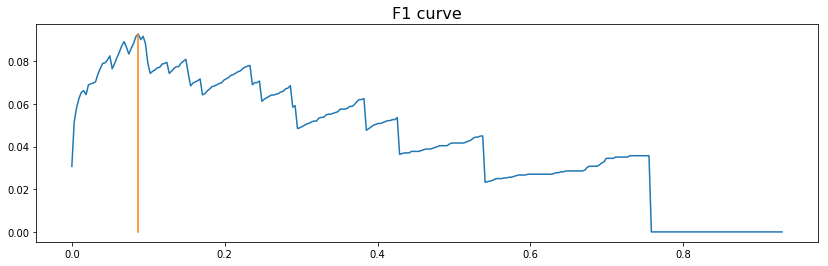

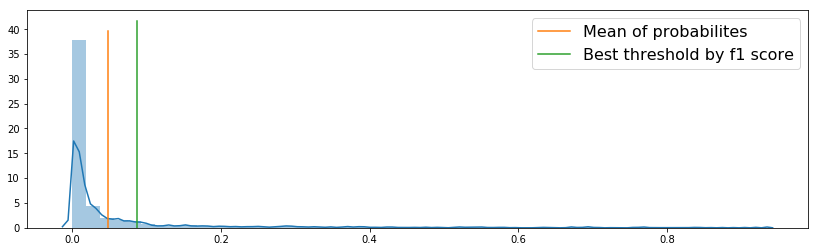

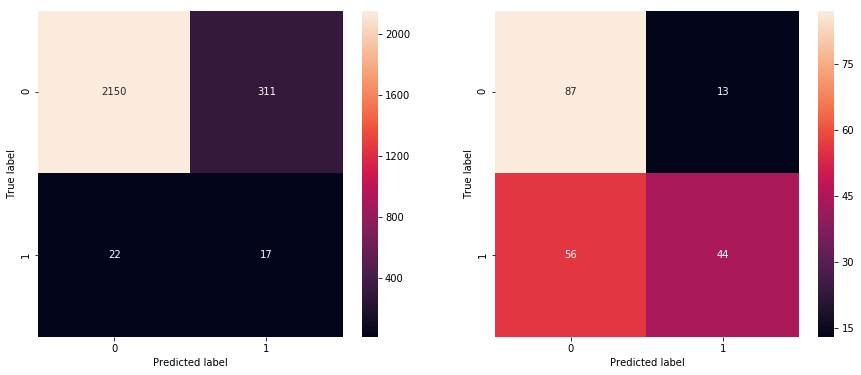

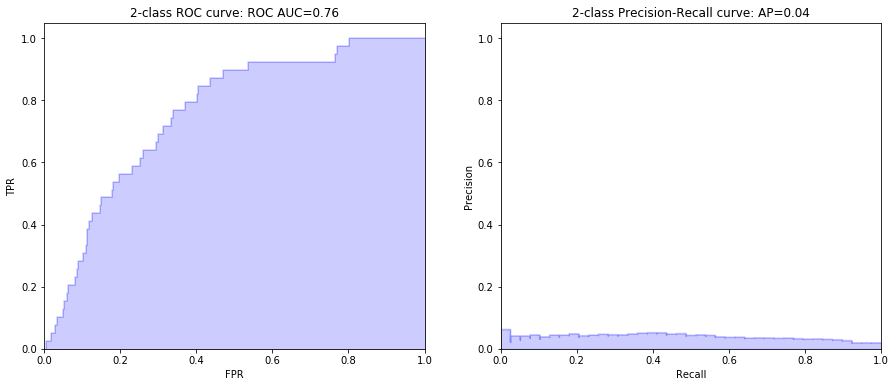

In [5]:
%%time 
model = LGBMClassifier(class_weight={0: y_train.mean(), 1: 1 - y_train.mean()})
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8138
PR AUC score: 0.0661
CPU times: user 44.2 s, sys: 1.05 s, total: 45.3 s
Wall time: 53.1 s


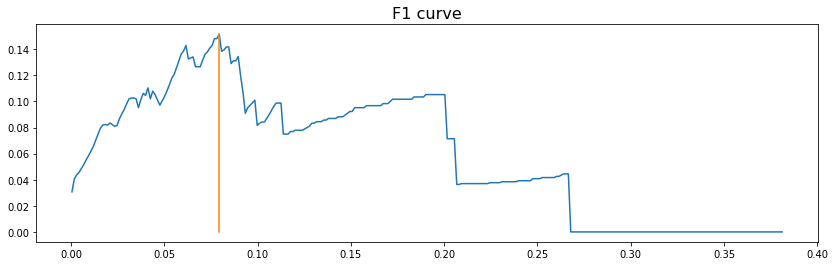

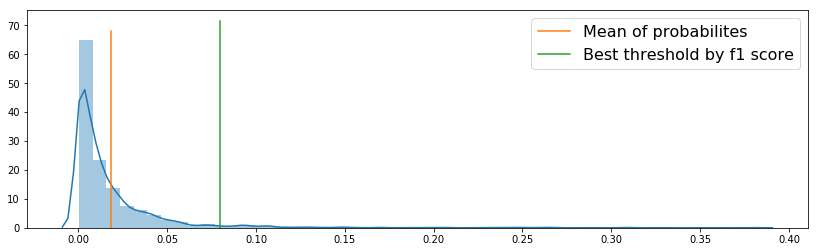

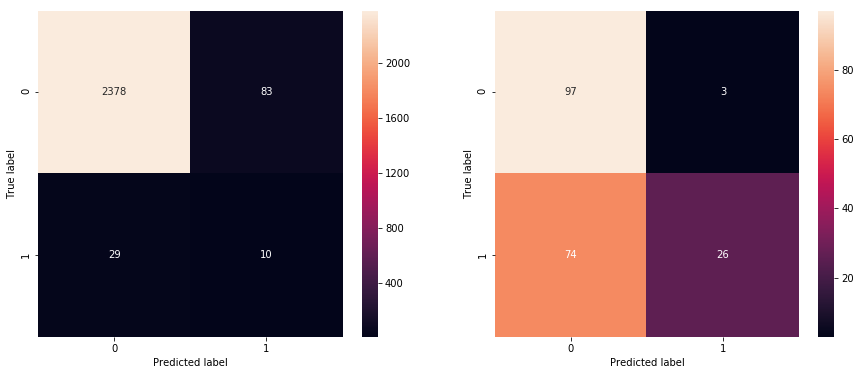

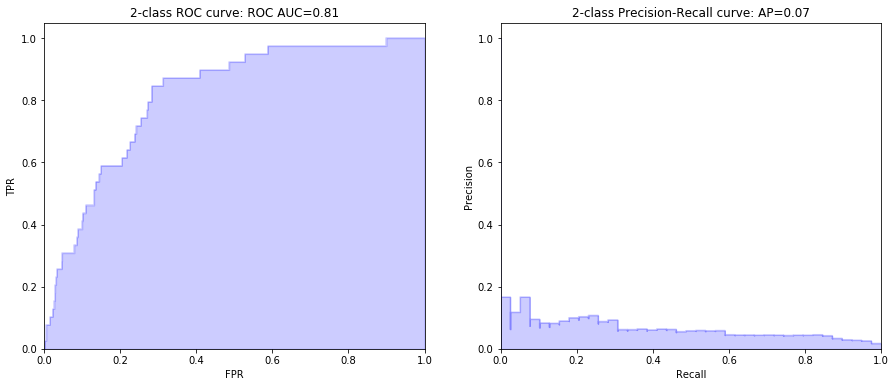

In [6]:
%%time 
model = XGBClassifier()
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Imbalanced Learning 

### 1 Over-sampling
#### 1.1 Naive random over-sampling

In [7]:
from imblearn.over_sampling import RandomOverSampler

In [8]:
%%time 
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

CPU times: user 380 ms, sys: 354 ms, total: 733 ms
Wall time: 947 ms


ROC AUC score: 0.7607
PR AUC score: 0.0377
CPU times: user 5.12 s, sys: 1.39 s, total: 6.52 s
Wall time: 5.59 s


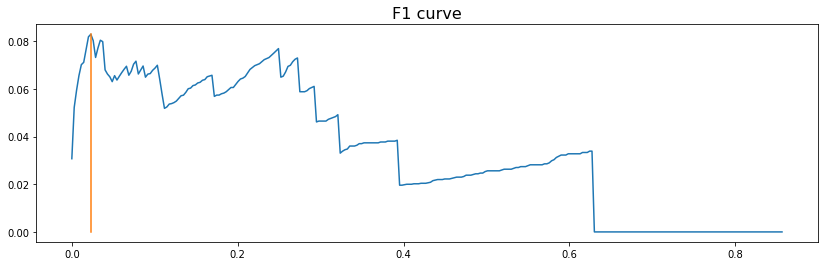

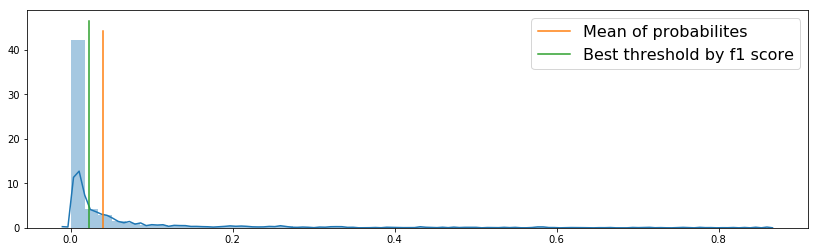

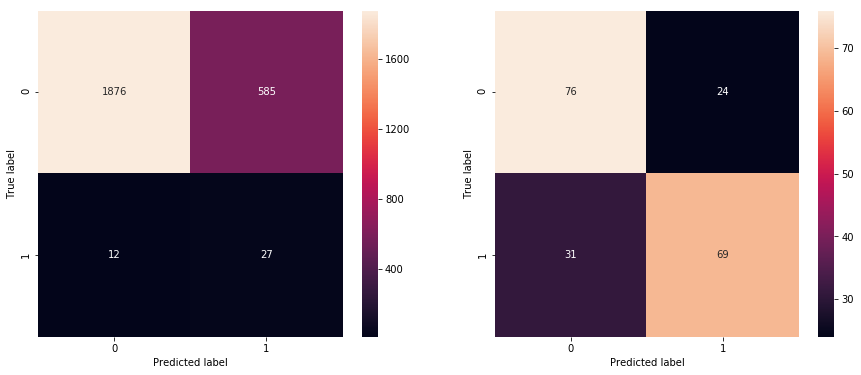

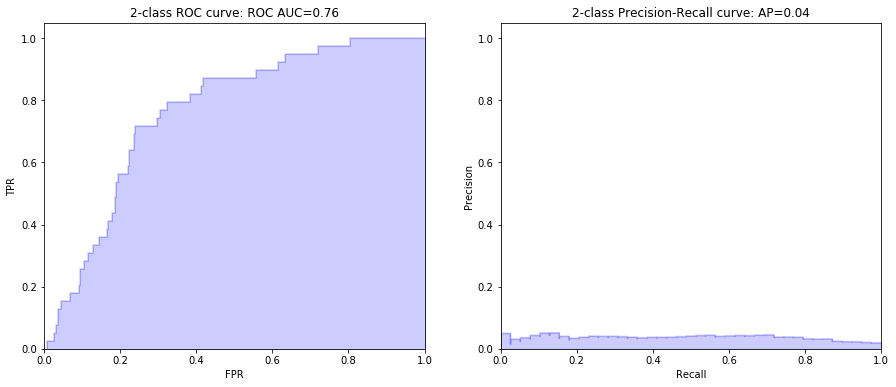

In [9]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8119
PR AUC score: 0.0633
CPU times: user 1min 22s, sys: 2.56 s, total: 1min 24s
Wall time: 1min 35s


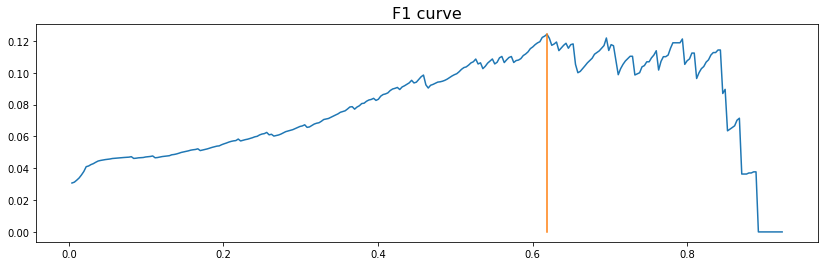

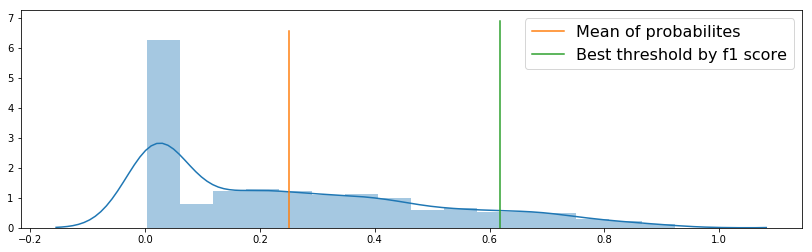

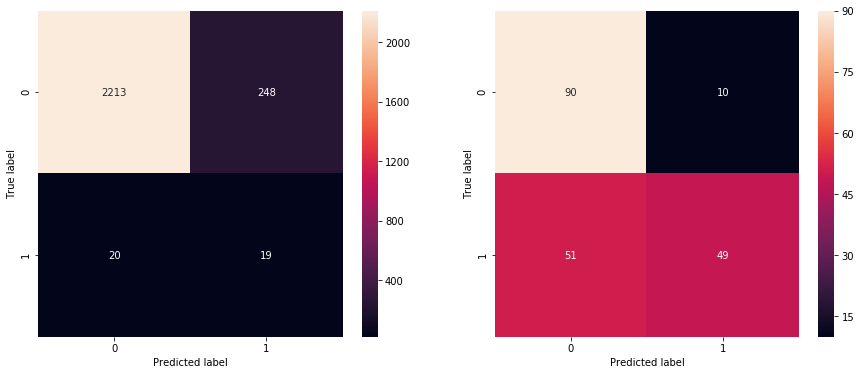

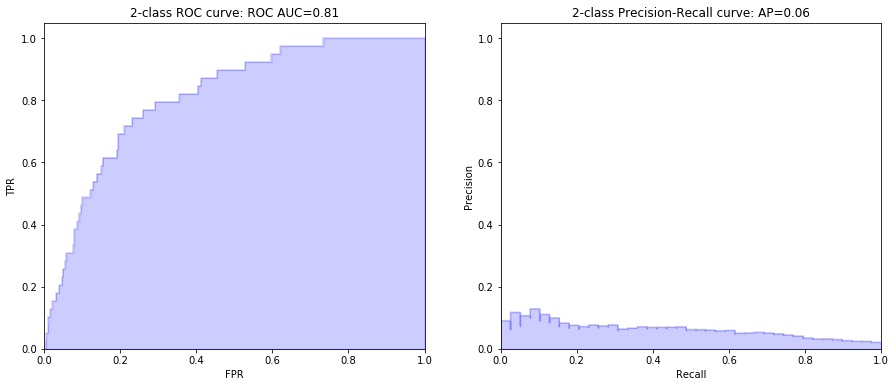

In [10]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.2  SMOTE: Synthetic Minority Oversampling Technique

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
%%time 
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

CPU times: user 735 ms, sys: 479 ms, total: 1.21 s
Wall time: 1.54 s


ROC AUC score: 0.7816
PR AUC score: 0.0437
CPU times: user 11.7 s, sys: 1.68 s, total: 13.3 s
Wall time: 8.67 s


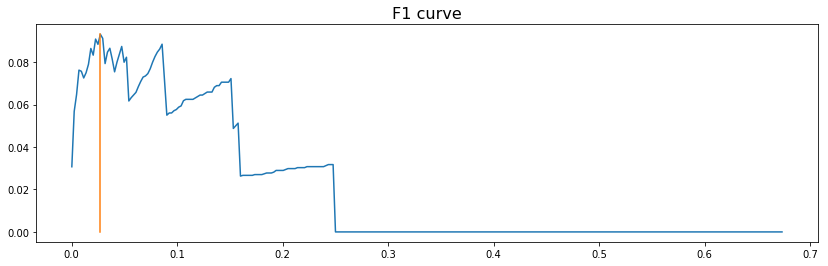

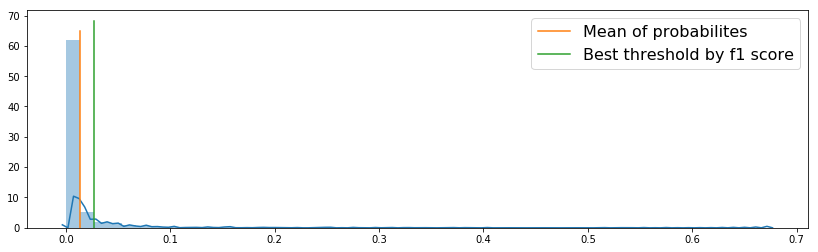

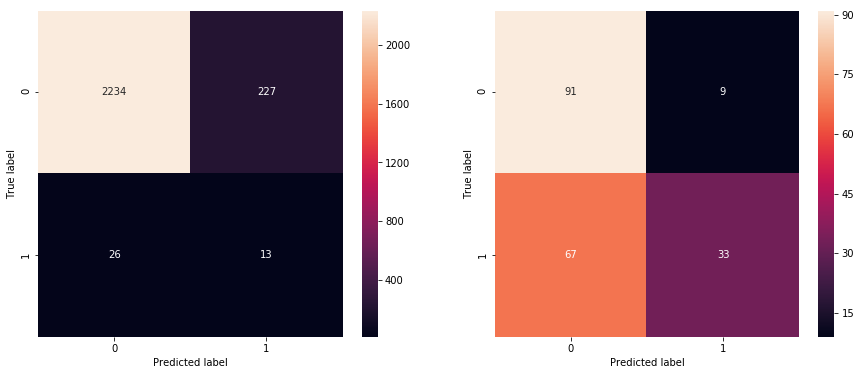

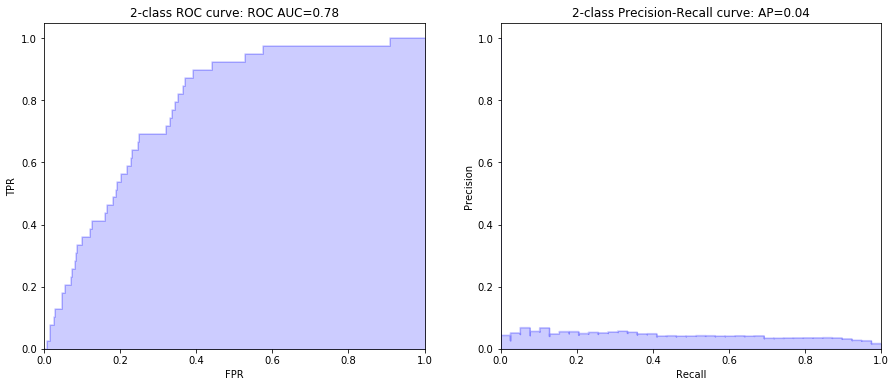

In [13]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.7987
PR AUC score: 0.0572
CPU times: user 1min 24s, sys: 3.68 s, total: 1min 28s
Wall time: 1min 47s


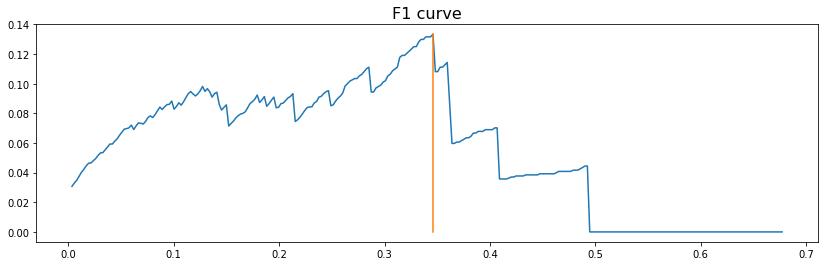

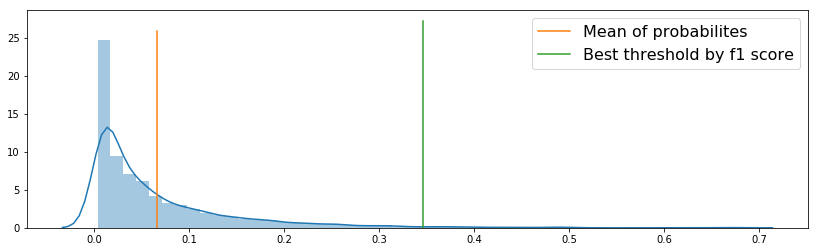

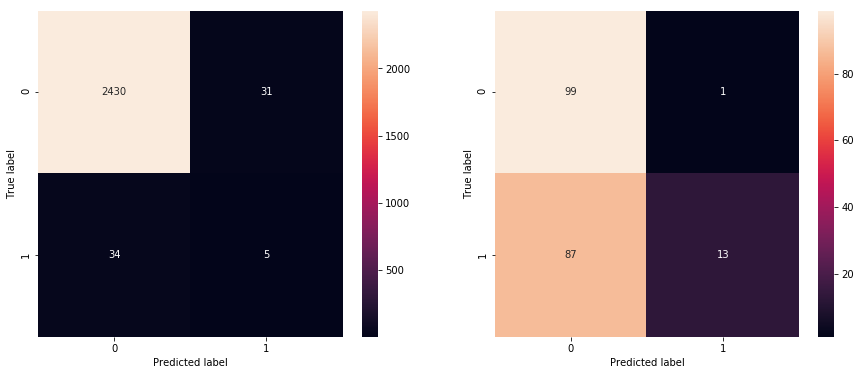

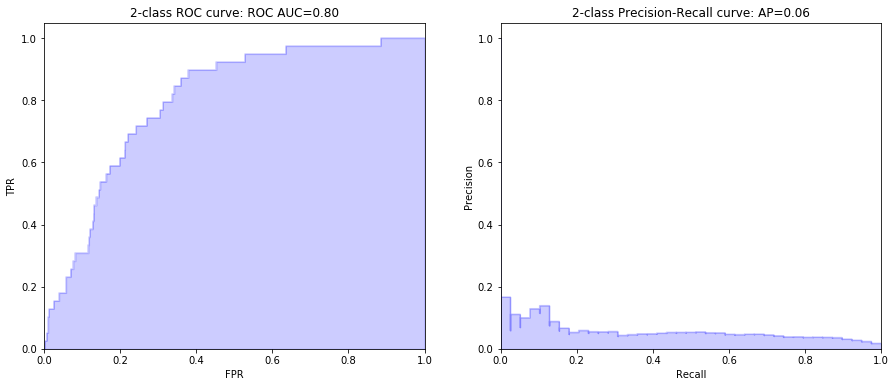

In [14]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 1.3 ADASYN: Adaptive Synthetic sampling method

In [15]:
from imblearn.over_sampling import ADASYN

In [16]:
%%time 
X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)

CPU times: user 1.85 s, sys: 690 ms, total: 2.54 s
Wall time: 2.97 s


ROC AUC score: 0.7787
PR AUC score: 0.0484
CPU times: user 11.2 s, sys: 1.63 s, total: 12.9 s
Wall time: 7.69 s


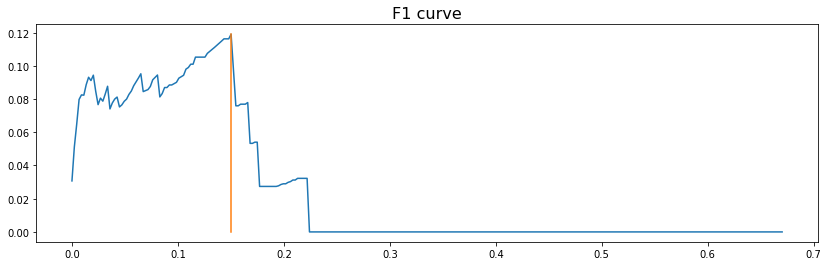

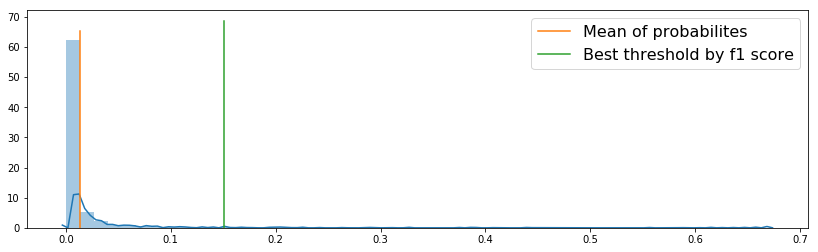

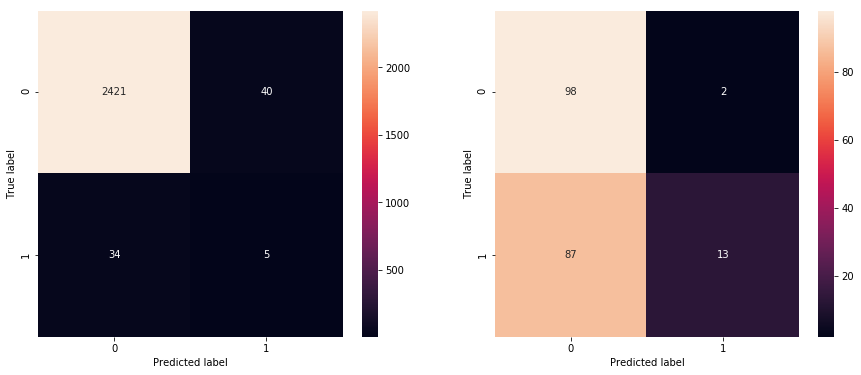

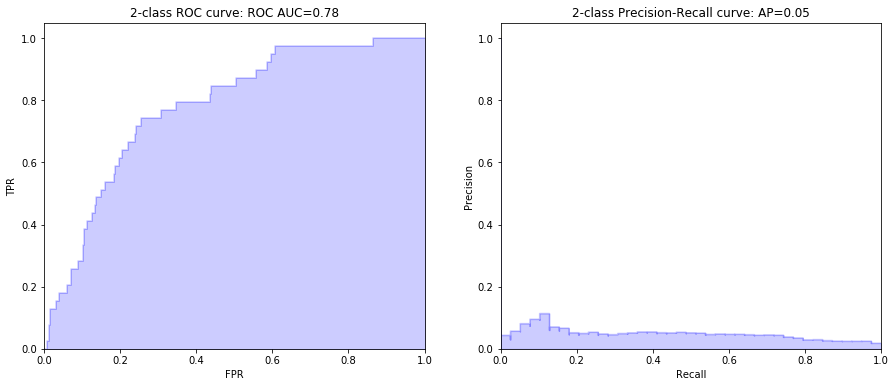

In [17]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.7829
PR AUC score: 0.0469
CPU times: user 1min 29s, sys: 9.26 s, total: 1min 38s
Wall time: 2min 1s


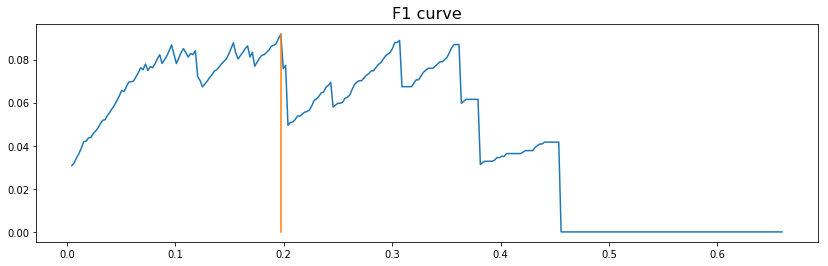

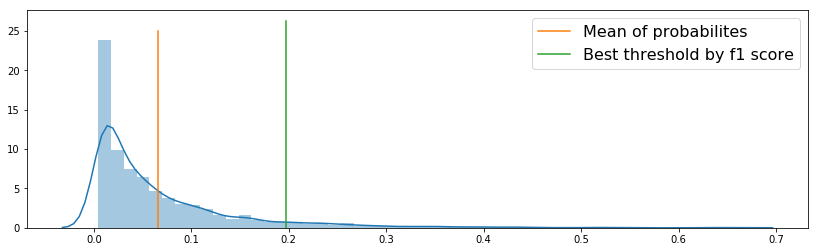

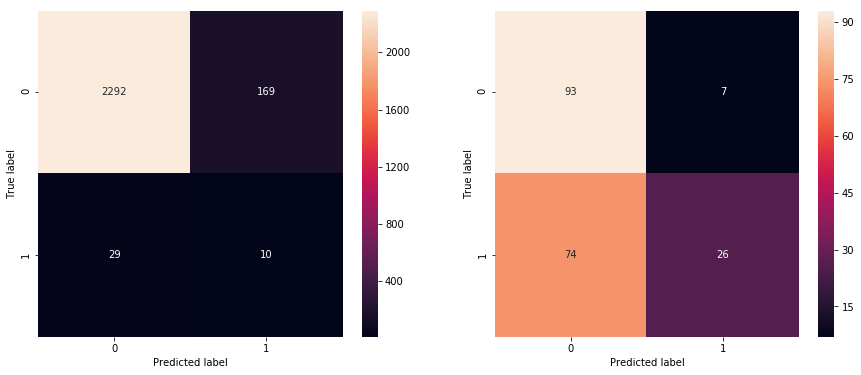

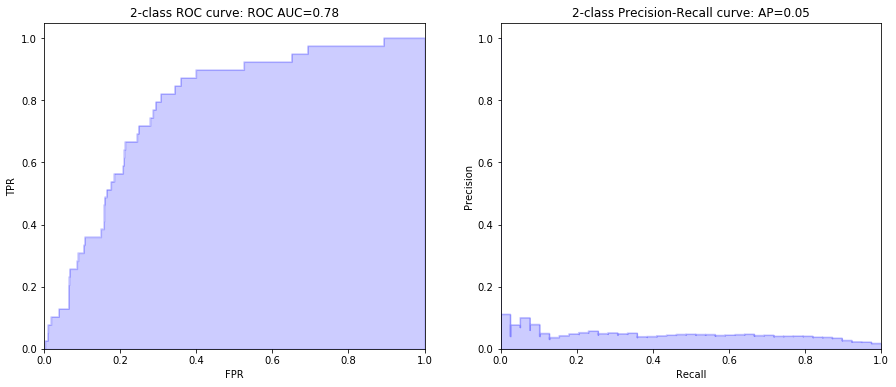

In [18]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 2 Under-sampling
#### 2.1  Controlled under-sampling techniques

In [19]:
from imblearn.under_sampling import RandomUnderSampler

In [20]:
%%time
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)

CPU times: user 308 ms, sys: 226 ms, total: 535 ms
Wall time: 768 ms


ROC AUC score: 0.7441
PR AUC score: 0.0355
CPU times: user 2.08 s, sys: 516 ms, total: 2.6 s
Wall time: 2.8 s


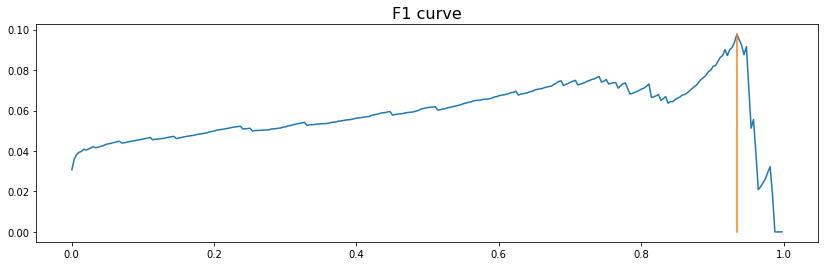

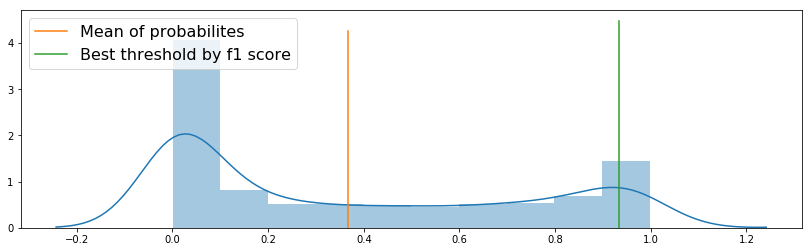

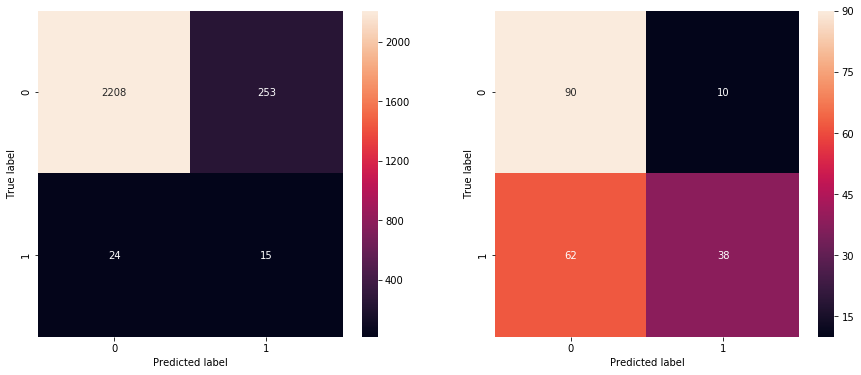

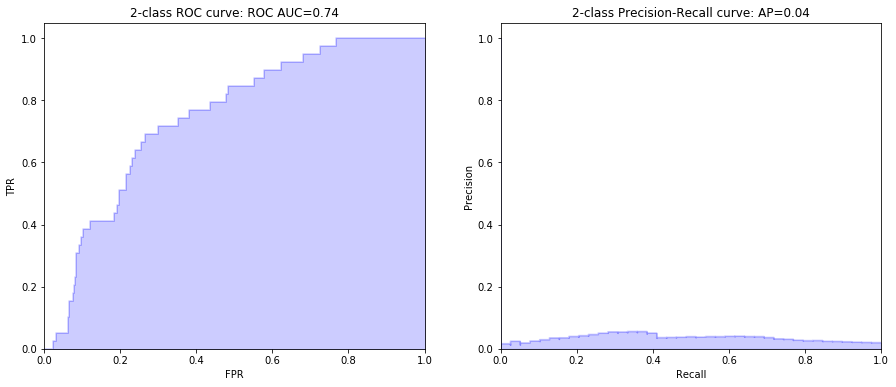

In [21]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.766
PR AUC score: 0.0397
CPU times: user 3.51 s, sys: 255 ms, total: 3.76 s
Wall time: 4.74 s


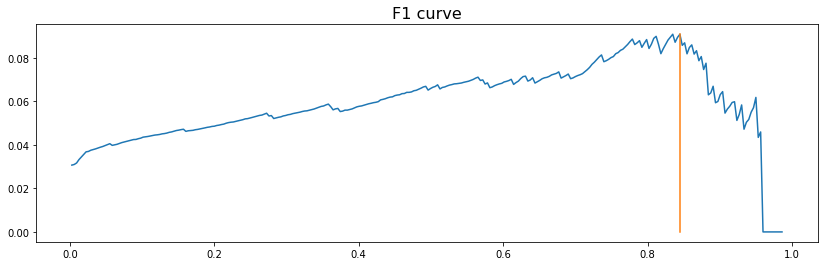

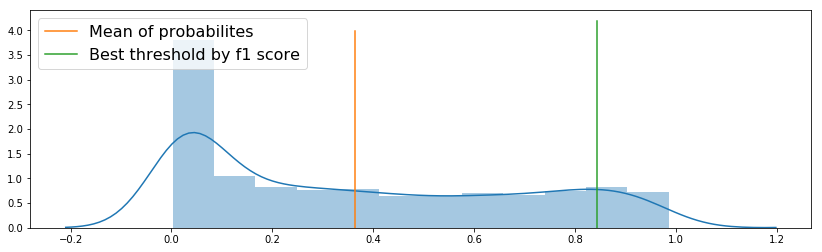

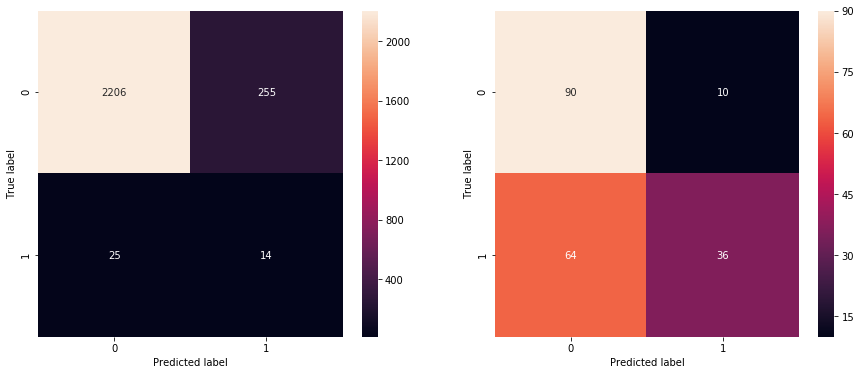

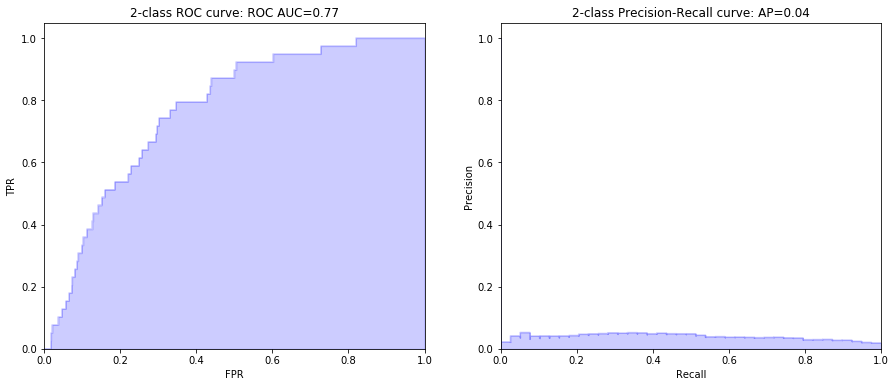

In [22]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.2 Cleaning under-sampling techniques

In [23]:
from imblearn.under_sampling import EditedNearestNeighbours

In [24]:
%%time
X_resampled, y_resampled = EditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

CPU times: user 9.53 s, sys: 842 ms, total: 10.4 s
Wall time: 11.9 s


ROC AUC score: 0.7648
PR AUC score: 0.0424
CPU times: user 3.85 s, sys: 1.5 s, total: 5.36 s
Wall time: 4.43 s


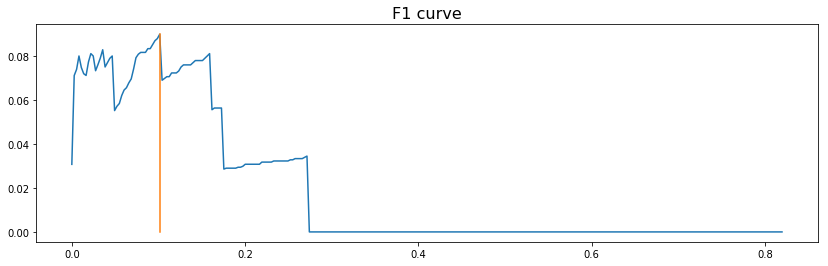

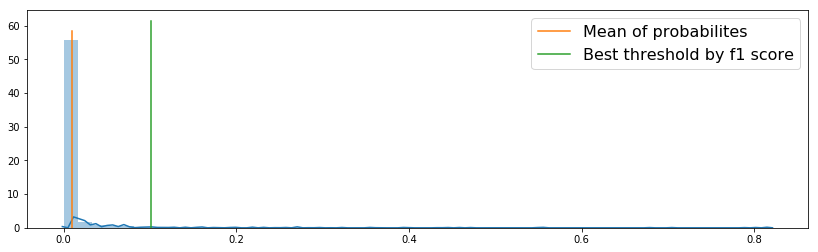

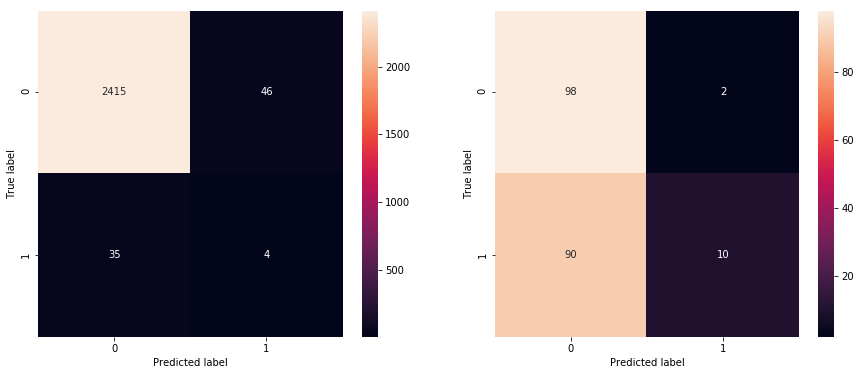

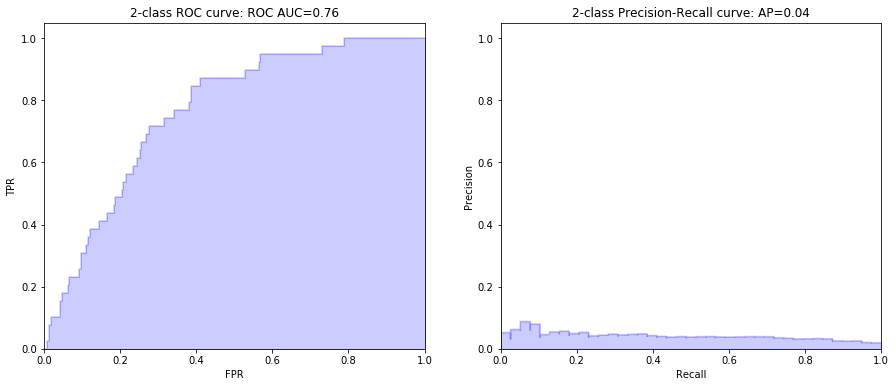

In [25]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.815
PR AUC score: 0.066
CPU times: user 38.9 s, sys: 808 ms, total: 39.7 s
Wall time: 42.2 s


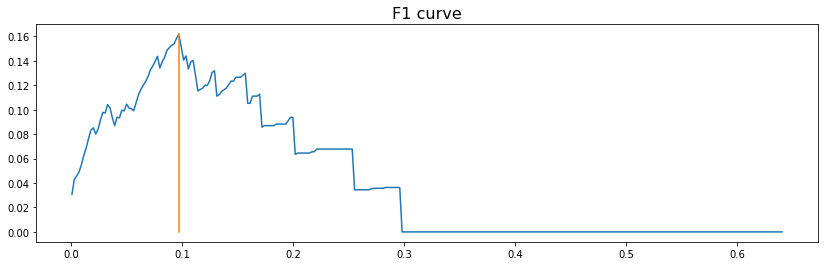

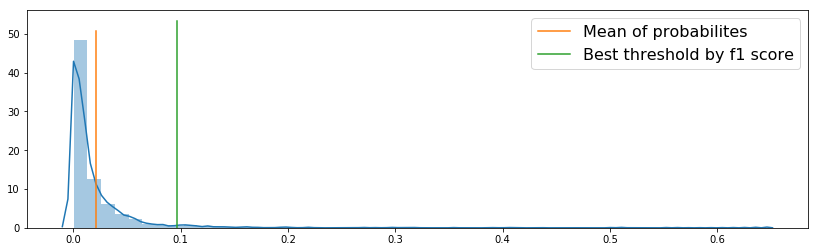

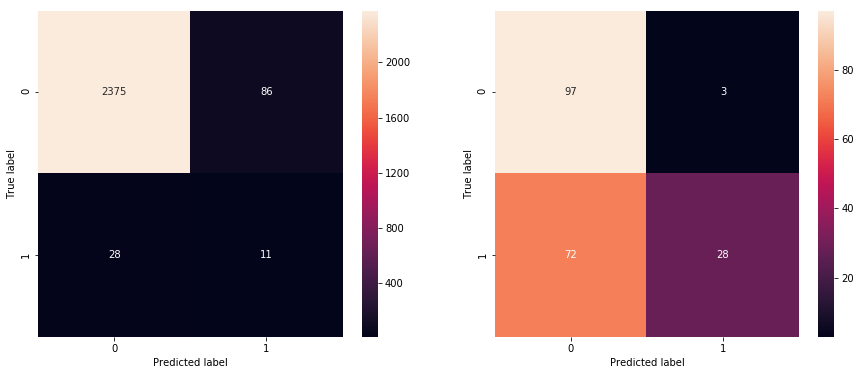

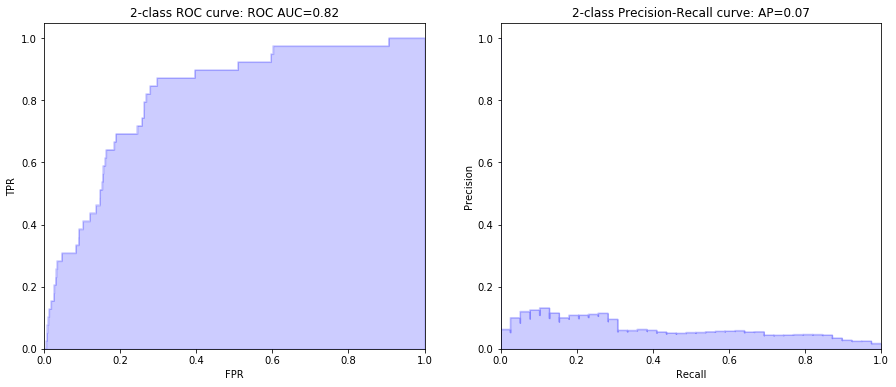

In [26]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [27]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

In [28]:
%%time
X_resampled, y_resampled = RepeatedEditedNearestNeighbours(random_state=0).fit_sample(X_train, y_train)

CPU times: user 1min 21s, sys: 3.53 s, total: 1min 25s
Wall time: 1min 33s


ROC AUC score: 0.7776
PR AUC score: 0.0528
CPU times: user 3.6 s, sys: 1.33 s, total: 4.93 s
Wall time: 4.03 s


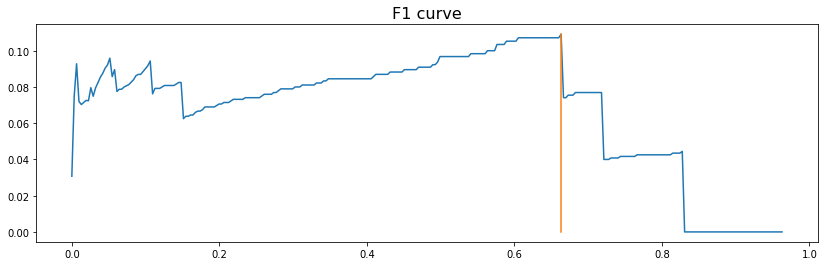

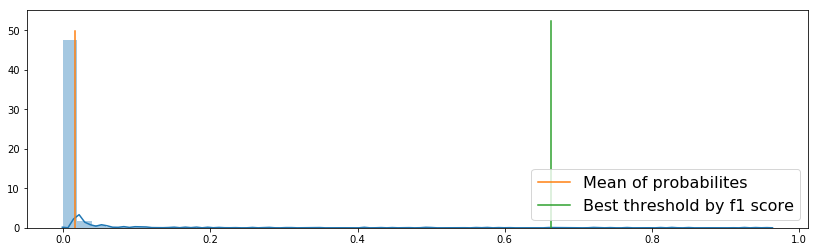

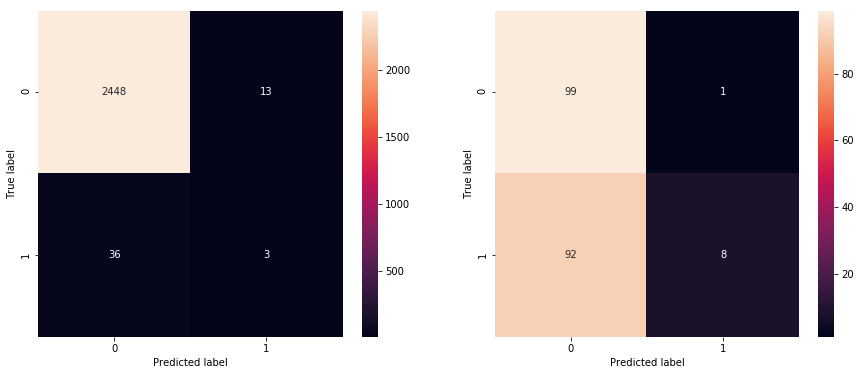

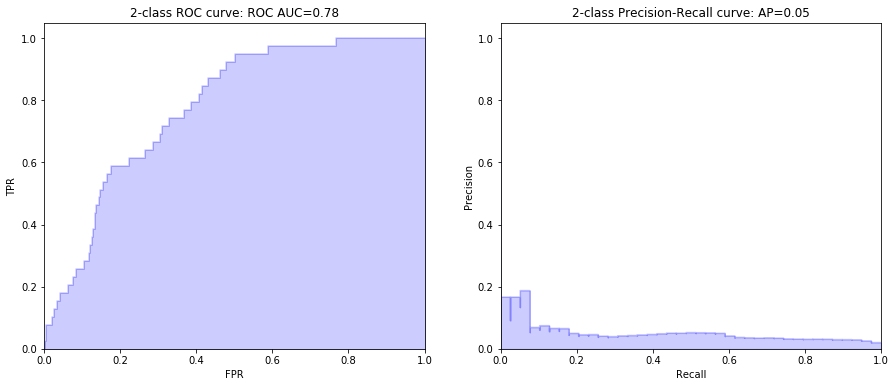

In [29]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.816
PR AUC score: 0.0659
CPU times: user 38.6 s, sys: 897 ms, total: 39.5 s
Wall time: 43.2 s


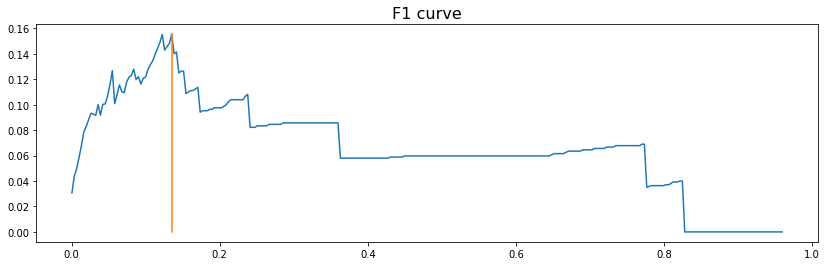

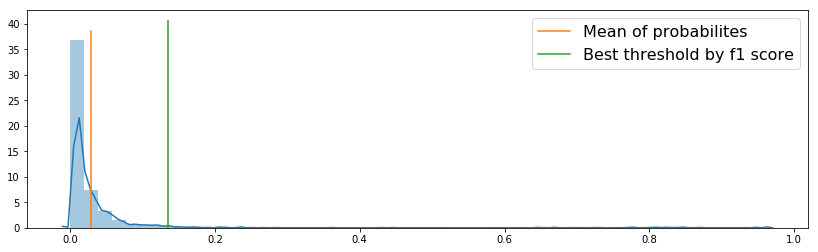

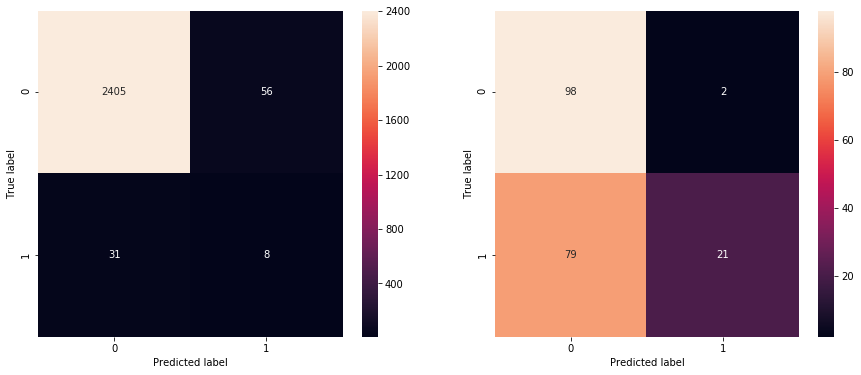

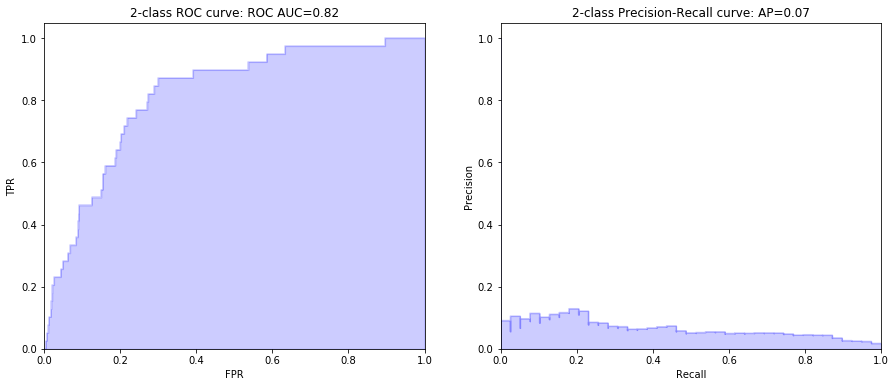

In [30]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

In [31]:
from imblearn.under_sampling import AllKNN

In [32]:
%%time
X_resampled, y_resampled = AllKNN(random_state=0).fit_sample(X_train, y_train)

CPU times: user 25.5 s, sys: 1.39 s, total: 26.9 s
Wall time: 30.4 s


ROC AUC score: 0.7835
PR AUC score: 0.0484
CPU times: user 3.99 s, sys: 1.47 s, total: 5.46 s
Wall time: 5.35 s


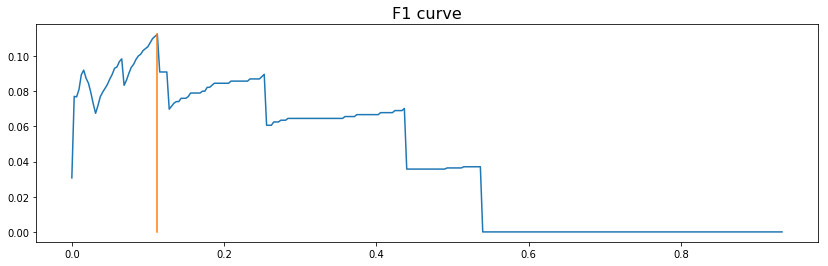

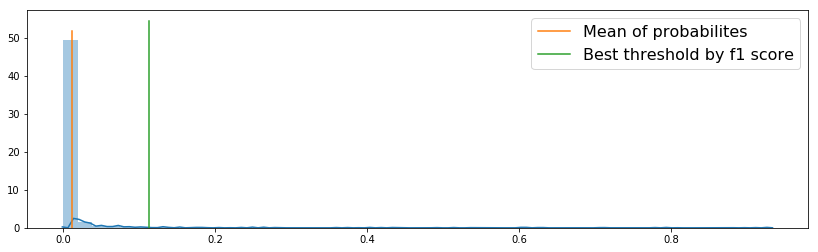

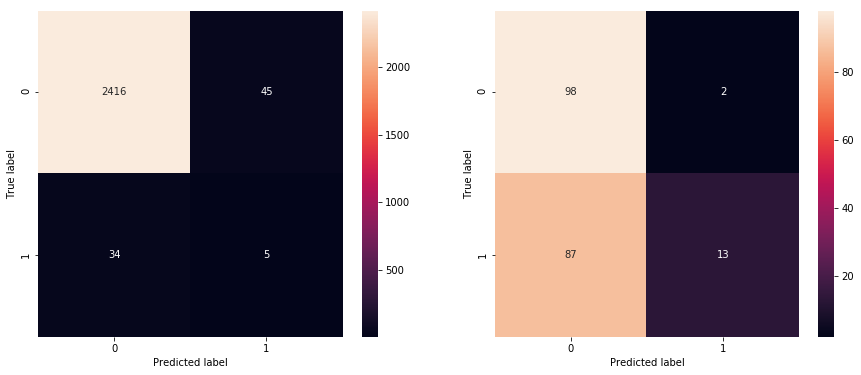

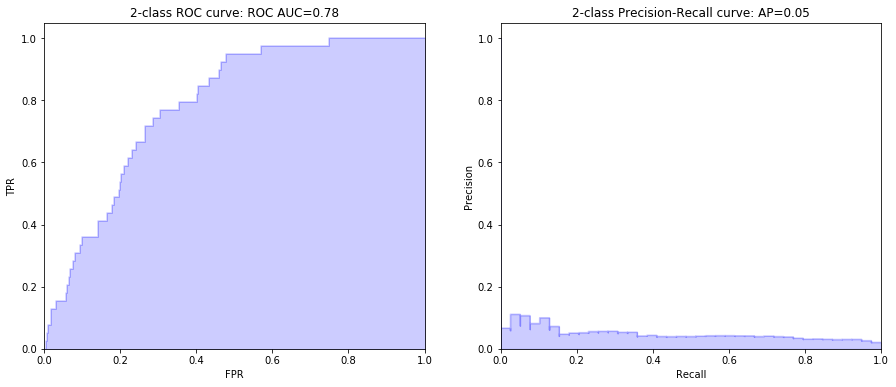

In [33]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.811
PR AUC score: 0.0675
CPU times: user 40.1 s, sys: 1.12 s, total: 41.2 s
Wall time: 49.5 s


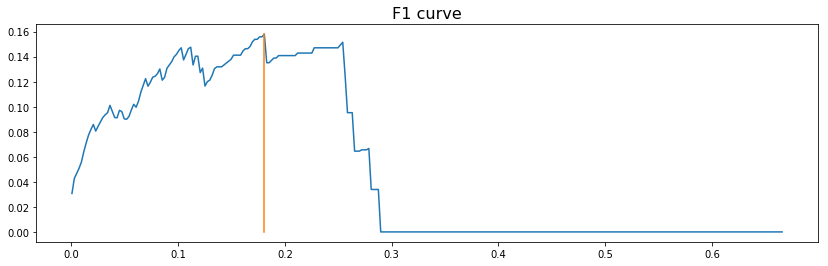

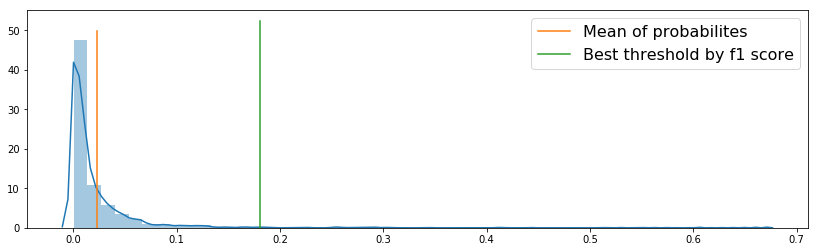

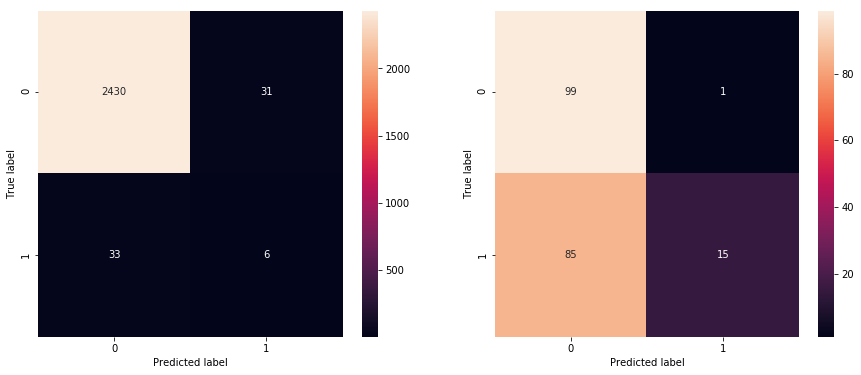

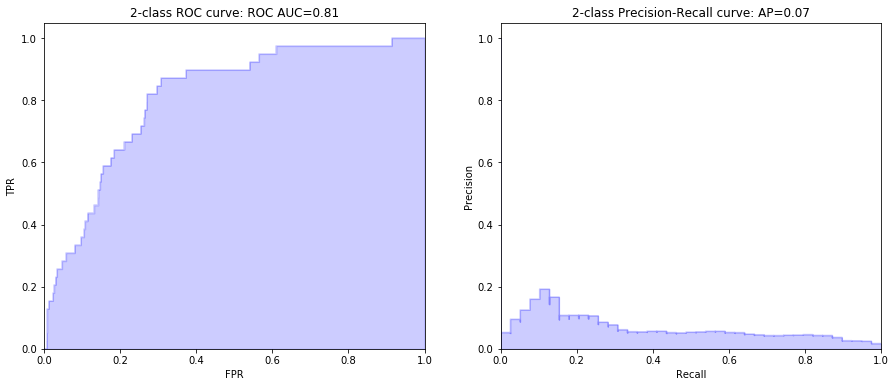

In [34]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

#### 2.3  Instance hardness threshold

In [35]:
from imblearn.under_sampling import InstanceHardnessThreshold

In [36]:
%%time
iht = InstanceHardnessThreshold(random_state=0)
X_resampled, y_resampled = iht.fit_sample(X_train, y_train)

CPU times: user 5.88 s, sys: 1.05 s, total: 6.93 s
Wall time: 8.51 s


ROC AUC score: 0.7765
PR AUC score: 0.043
CPU times: user 3.83 s, sys: 1.32 s, total: 5.15 s
Wall time: 4.47 s


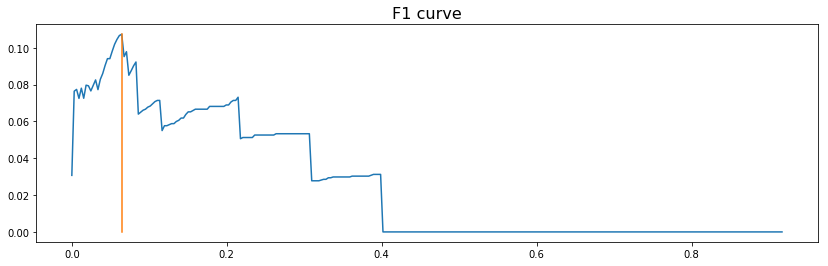

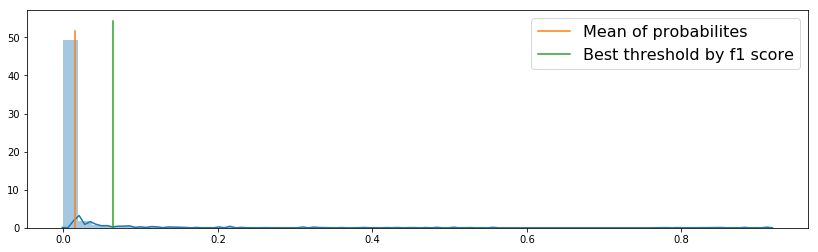

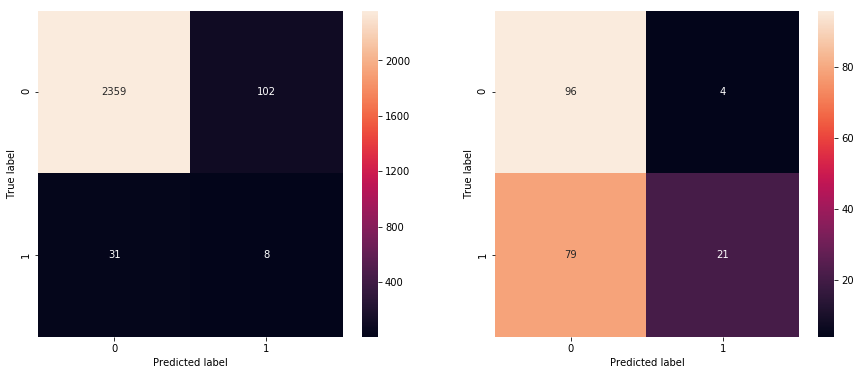

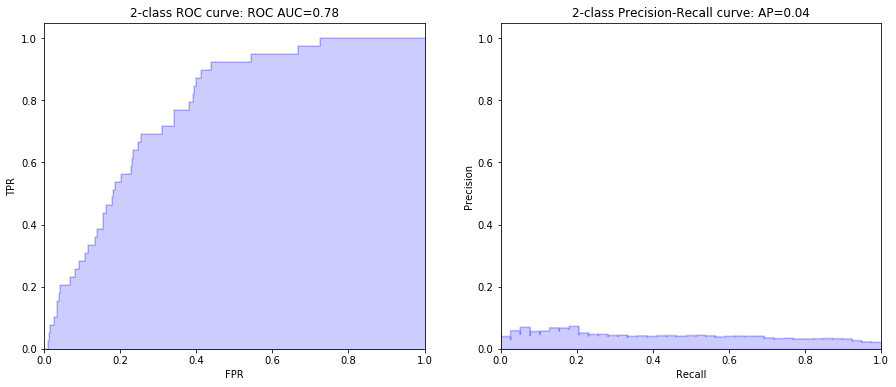

In [37]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8187
PR AUC score: 0.0588
CPU times: user 37.6 s, sys: 1.32 s, total: 38.9 s
Wall time: 44.3 s


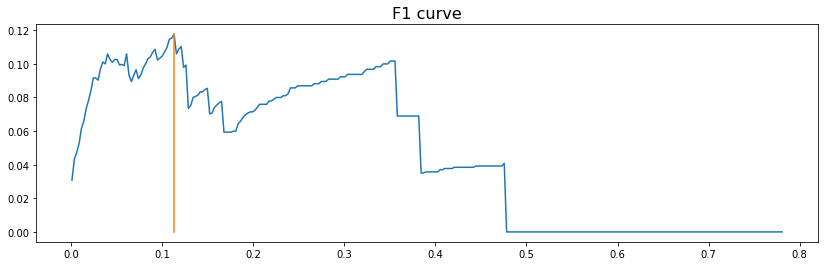

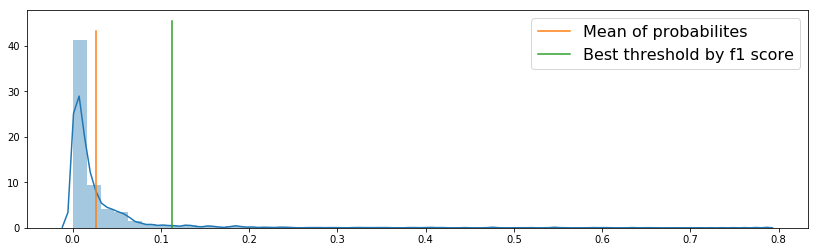

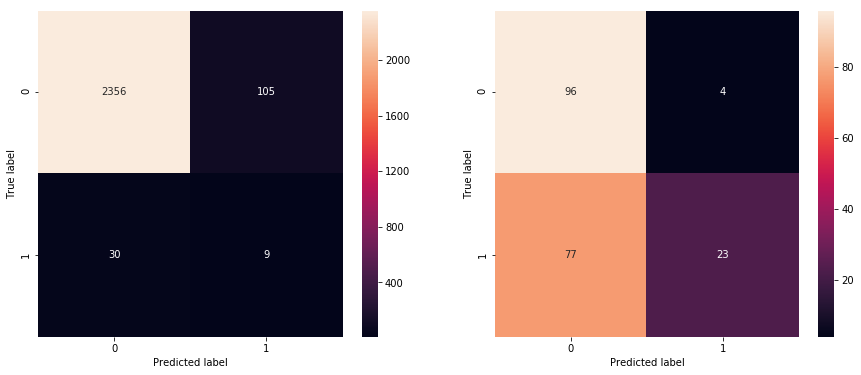

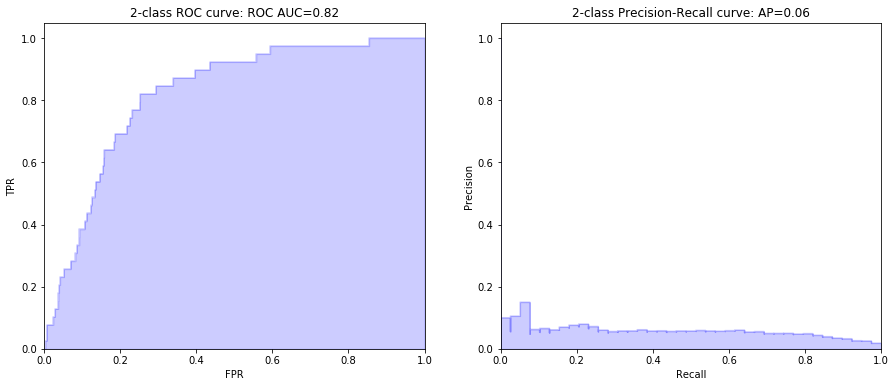

In [38]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 3 Combination of over- and under-sampling

In [39]:
from imblearn.combine import SMOTEENN

In [40]:
%%time
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)

CPU times: user 18.9 s, sys: 1.48 s, total: 20.4 s
Wall time: 30.4 s


ROC AUC score: 0.7985
PR AUC score: 0.047
CPU times: user 11.3 s, sys: 1.66 s, total: 12.9 s
Wall time: 10.3 s


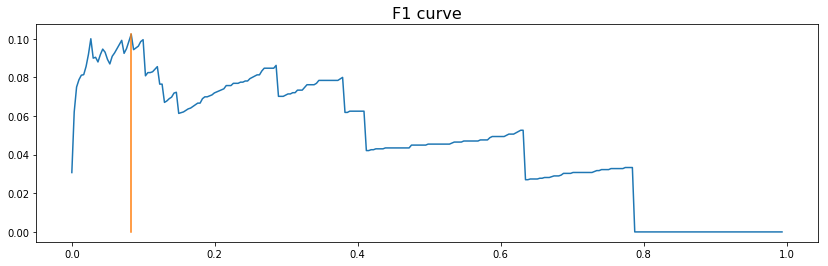

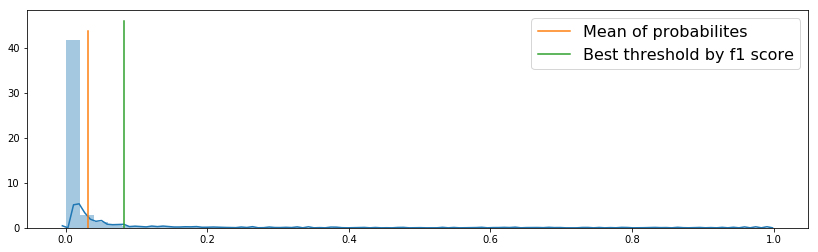

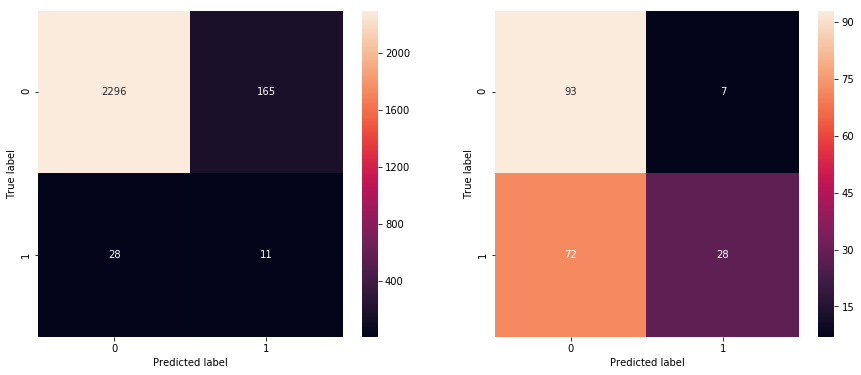

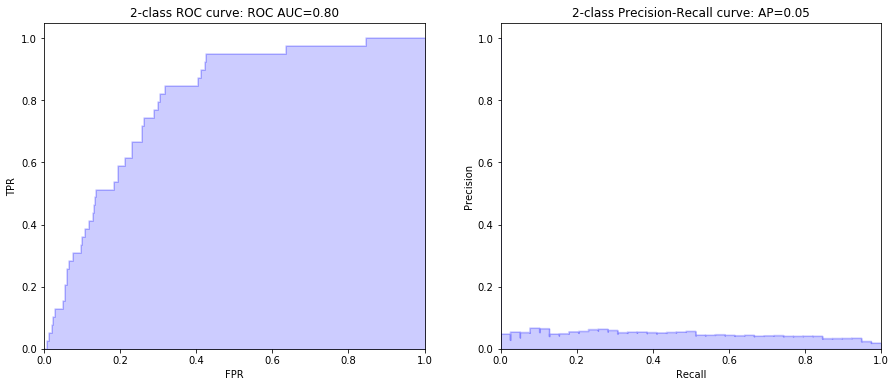

In [41]:
%%time 

model = LGBMClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8144
PR AUC score: 0.054
CPU times: user 1min 27s, sys: 21.7 s, total: 1min 49s
Wall time: 2min 40s


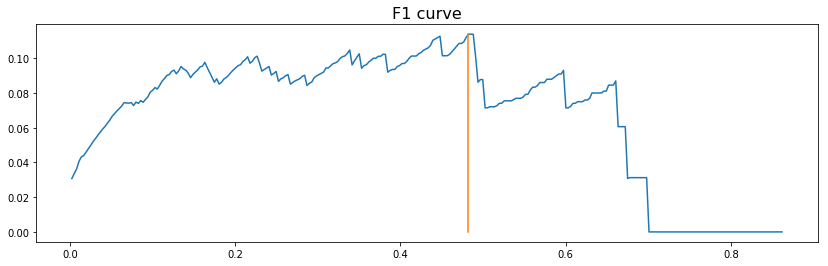

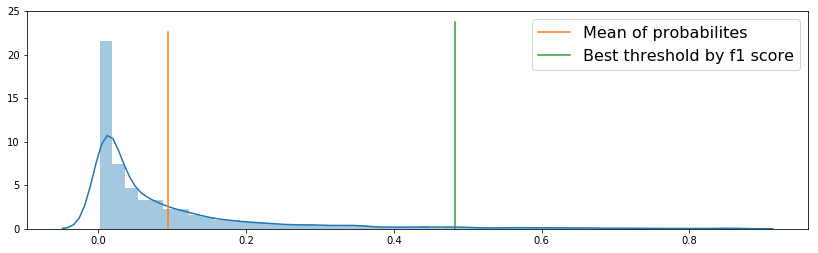

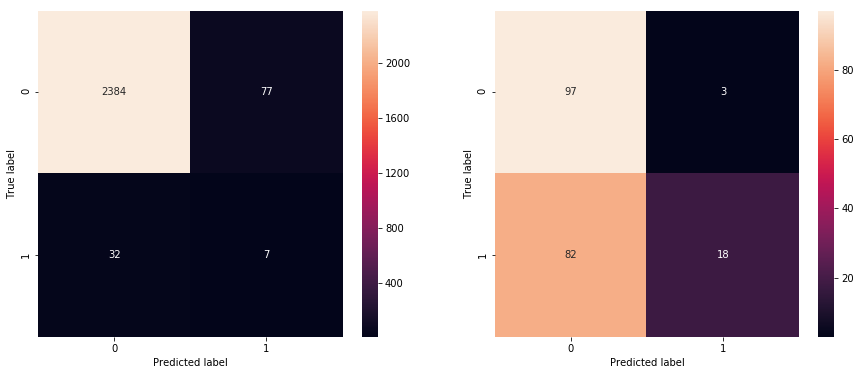

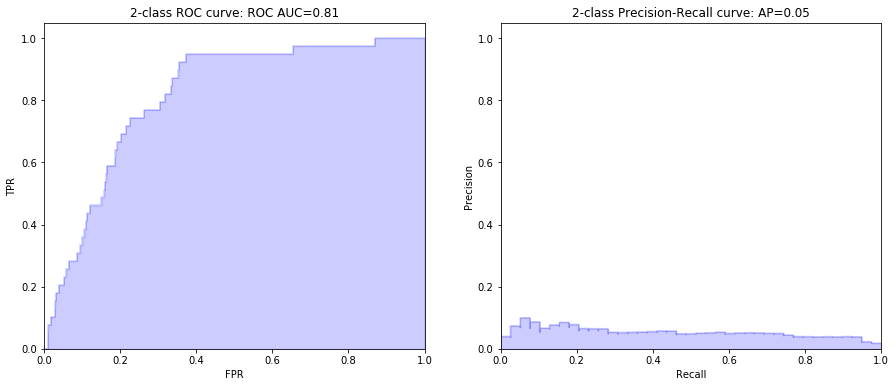

In [42]:
%%time 

model = XGBClassifier()
model.fit(X_resampled, y_resampled)

prediction_proba = model.predict_proba(X_test.values)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

### 4 Ensemble of samplers

In [43]:
from imblearn.ensemble import BalancedBaggingClassifier

ROC AUC score: 0.7877
PR AUC score: 0.0476
CPU times: user 11.3 s, sys: 4.25 s, total: 15.5 s
Wall time: 23.7 s


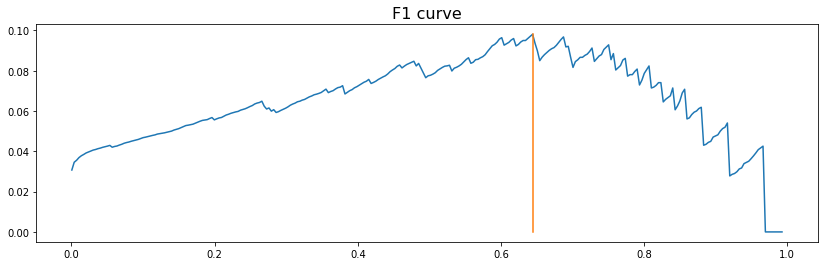

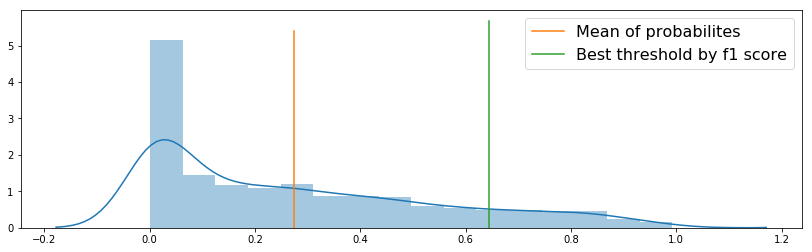

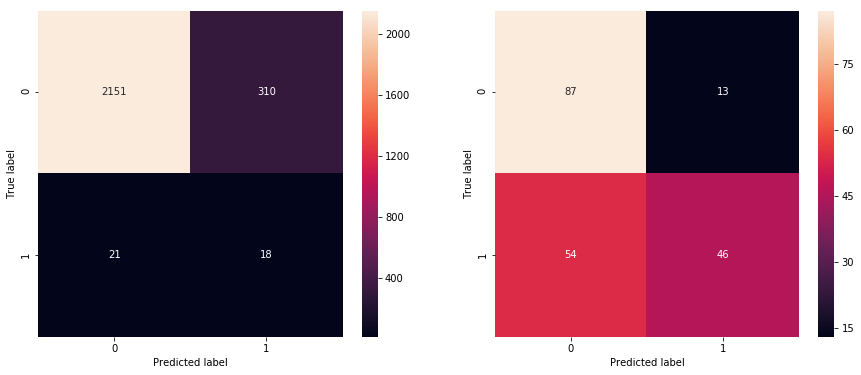

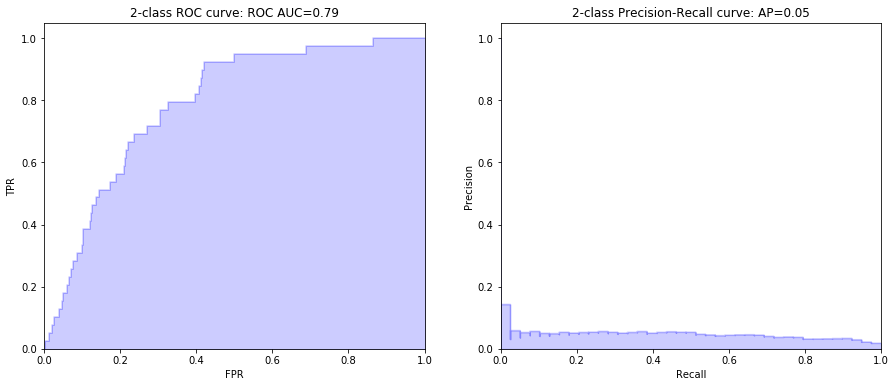

In [44]:
%%time 

model = BalancedBaggingClassifier(base_estimator=LGBMClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

ROC AUC score: 0.8017
PR AUC score: 0.0529
CPU times: user 28.7 s, sys: 4.16 s, total: 32.8 s
Wall time: 41.9 s


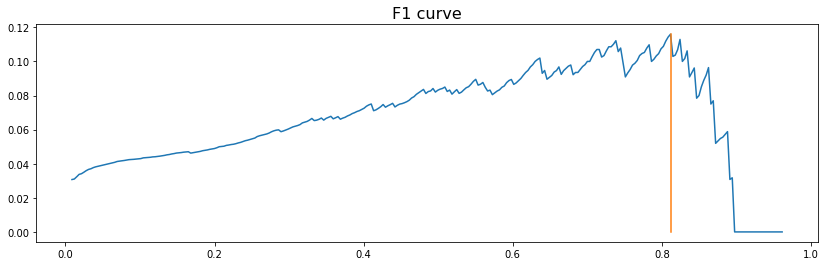

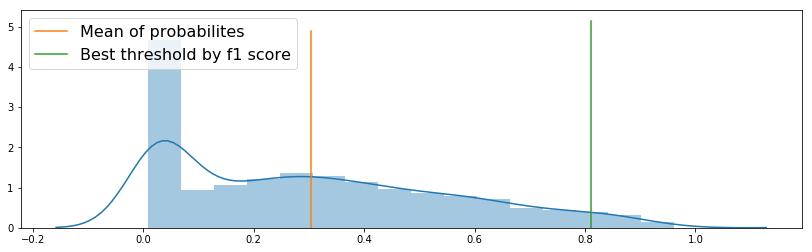

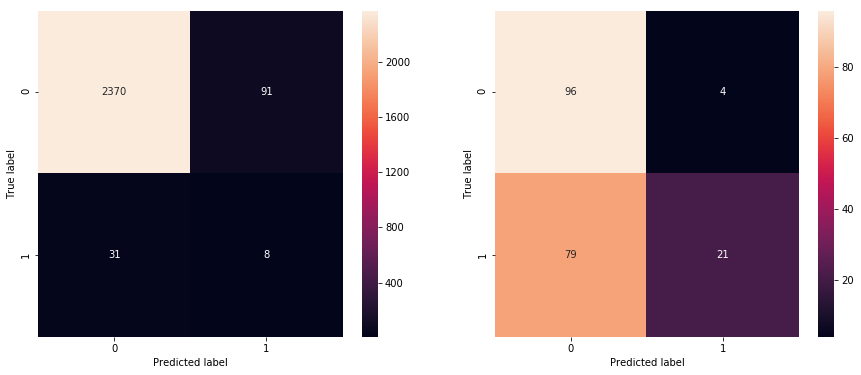

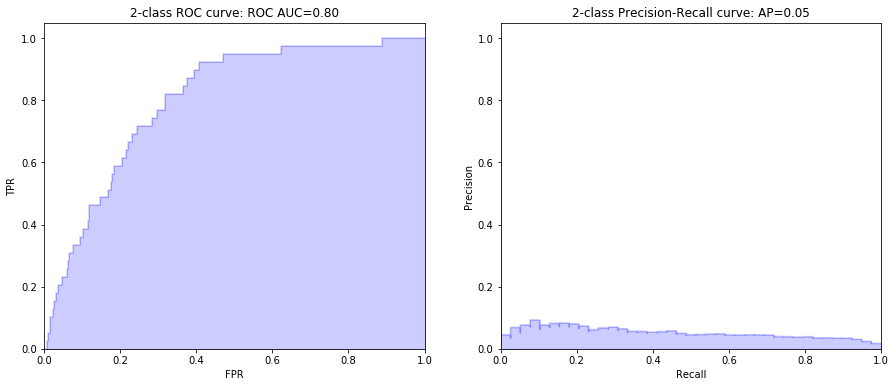

In [45]:
%%time 

model = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                 ratio='auto',
                                 replacement=False,
                                 random_state=0)
model.fit(X_train, y_train)

prediction_proba = model.predict_proba(X_test)
prediction = prediction_proba[:, 1] > get_threshold_by_f1(prediction_proba, y_test, plot=True)
plot_probas(prediction_proba, y_test)

get_roc_auc_score(prediction_proba, y_test)
get_pr_auc_score(prediction_proba, y_test)

plot_confusion_matrix(prediction, y_test)
plot_curves(prediction_proba, y_test)

## Balancing data

w =  15
ROC AUC score: 0.7694
PR AUC score: 0.041
w =  20
ROC AUC score: 0.7676
PR AUC score: 0.0393
w =  25
ROC AUC score: 0.7696
PR AUC score: 0.0382
w =  30
ROC AUC score: 0.7553
PR AUC score: 0.0355
w =  35
ROC AUC score: 0.7743
PR AUC score: 0.041
w =  40
ROC AUC score: 0.7705
PR AUC score: 0.0404
w =  45
ROC AUC score: 0.7406
PR AUC score: 0.0376
w =  50
ROC AUC score: 0.7573
PR AUC score: 0.0381


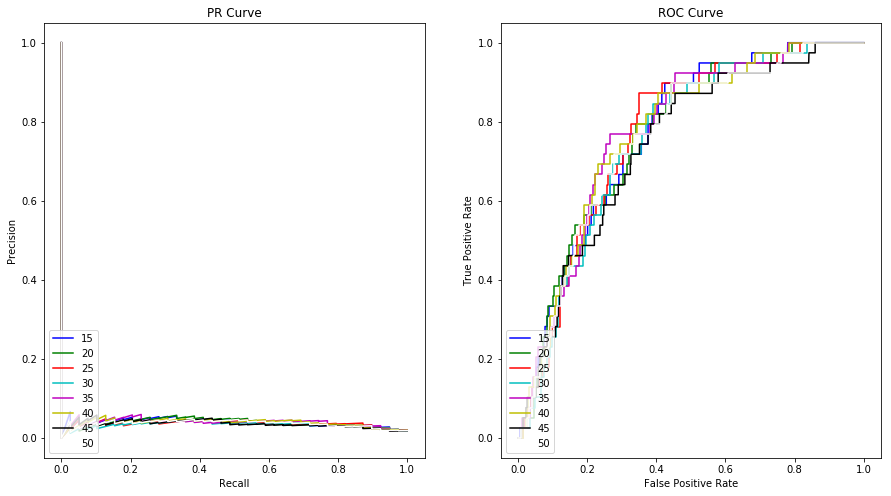

In [46]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip(np.arange(15, 200, 5),'bgrcmykw'):
    lr_model = LGBMClassifier(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]
    print('w = ', w) 
    get_roc_auc_score(lr_model.predict_proba(X_test), y_test)
    get_pr_auc_score (lr_model.predict_proba(X_test), y_test)
    
    p,r,_ = precision_recall_curve(y_test, pred_prob)
    tpr,fpr,_ = roc_curve(y_test, pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()